In [ ]:
import torch
from transformers import CLIPProcessor, CLIPModel
import numpy as np
from PIL import Image
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


## Load CLIP model

In [ ]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

## Function to get text embeddings


In [ ]:
def get_text_embedding(text):
    modified_text = "a photo of a " + text
    inputs = processor(text=[modified_text], return_tensors="pt", padding=True)

    with torch.no_grad():
        text_features = model.get_text_features(**inputs)

    text_features = text_features / text_features.norm(dim=-1, keepdim=True)
    text_embedding = text_features.cpu().numpy().flatten()

    return text_embedding

## Function to get image embeddings

In [ ]:
def get_image_embedding(image_path):
    image = Image.open(image_path)
    inputs = processor(images=image, return_tensors="pt")

    with torch.no_grad():
        image_features = model.get_image_features(**inputs)

    image_features = image_features / image_features.norm(dim=-1, keepdim=True)
    image_embedding = image_features.cpu().numpy().flatten()

    return image_embedding

## *بخش اول*

###  الف - ج

In [ ]:
def similarity(vec1, vec2):
    return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

text_embedding = {}
for text in ["king", "queen", "man", "woman"]:
    text_features = get_text_embedding(text)
    text_embedding[text] = text_features

queen_vector = text_embedding["king"] - text_embedding["man"] + text_embedding["woman"]

queen_similarities = {text: similarity(queen_vector, embedding) for text, embedding in text_embedding.items()}
print(f"Similarities of 'king-man+queen' vector: {queen_similarities}")



Similarities of 'king-man+queen' vector: {'king': 0.94169015, 'queen': 0.9721398, 'man': 0.8605772, 'woman': 0.9225166}


The output illustrates the similarities of the vector king - man + woman to the embeddings of the words "king", "queen", "man", and "woman". The similarities are calculated using cosine similarity, which measures how close two vectors are in direction. Here's an analysis of the results:

1. ***King***: The similarity between the king - man + woman vector and "king" is 0.9417. This is a high similarity, indicating that the resulting vector is quite close to the "king" vector. This makes sense because the calculation is based on the word "king" and its relationship with "man" and "woman".

2. ***Queen***: The similarity with "queen" is 0.9721, which is the highest similarity. This suggests that the resulting vector king - man + woman is most similar to "queen", which makes sense based on the word analogy: "king" is related to "man" as "queen" is related to "woman".

3. ***Man***: The similarity with "man" is 0.8606. This is lower than both "king" and "queen", but it still shows a reasonable level of similarity.

4. ***Woman***: The similarity with "woman" is 0.9225, which is significant. This result shows that the model is detecting the relationship between "king", "man", and "woman", as "woman" is quite similar to the resulting vector.

### د

The highest similarity for each word is with itself, which is reasonable, as the embeddings for a word and its associated image are expected to be the closest. Also gender relations are clearly distinguished in the results:
* "King" is more similar to "man" than "woman" and "queen."
* "Queen" is more closely related to "woman" than "man" and "king."
* "Man" is more closely related to "king" than "queen" and "woman."
* "Woman" is most similar to "queen," as both are female-related, but also sh

Similarities between each text and images:
	 king {'king': 0.2689167, 'man': 0.23162489, 'queen': 0.21766981, 'woman': 0.21056995}
	 queen {'king': 0.23237726, 'man': 0.20280606, 'queen': 0.26736933, 'woman': 0.2585868}
	 man {'king': 0.23636144, 'man': 0.24830343, 'queen': 0.19425572, 'woman': 0.23253265}
	 woman {'king': 0.20970571, 'man': 0.20522012, 'queen': 0.25533217, 'woman': 0.27584314}


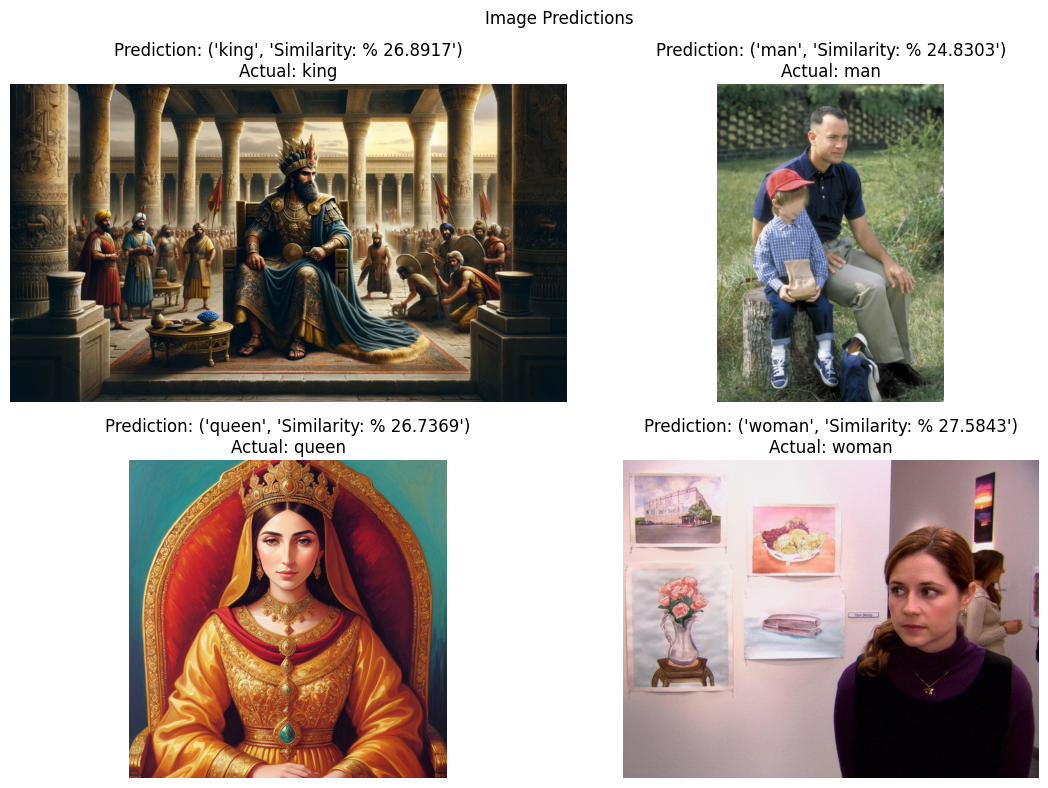

In [ ]:
image_paths = ["Image1.jpg", "Image2.jpg", "Image3.jpg", "Image4.jpg"]
image_labels = {"Image1.jpg": "king", "Image2.jpg": "man", "Image3.jpg": "queen", "Image4.jpg": "woman"}

image_embeddings = []
for image_path in image_paths:
    image_features = get_image_embedding(image_path)
    image_embeddings.append(image_features)

# Calculate similarity between each image and each text, and find the most similar image for each text
print("Similarities between each text and images:")
most_similar_images = {}
for text, embedding in text_embedding.items():
    similarities = [similarity(embedding, img_emb) for img_emb in image_embeddings]
    similarity_image_dictionary = {text: accuracy for text, accuracy in zip(["king", "man", "queen", "woman"], similarities)}
    print("\t", text, similarity_image_dictionary)
    most_similar_image_idx = np.argmax(similarities)
    most_similar_images[text] = (image_labels[image_paths[most_similar_image_idx]], f"Similarity: %{similarities[most_similar_image_idx]*100: .4f}")

# Find the most similar image to the computed queen_vector
queen_similarities = [similarity(queen_vector, img_emb) for img_emb in image_embeddings]
most_similar_queen_image_idx = np.argmax(queen_similarities)
most_similar_images["queen_vector"] = (image_paths[most_similar_queen_image_idx], queen_similarities[most_similar_queen_image_idx])

plt.figure(figsize=(12, 8))
for i, image_path in enumerate(image_paths):
    image = Image.open(image_path)
    plt.subplot(2, 2, i+1)
    plt.imshow(image)
    plt.axis('off')

    plt.title(f"Prediction: {most_similar_images[image_labels[image_path]]}\nActual: {image_labels[image_path]}")

plt.suptitle("Image Predictions")
plt.tight_layout()
plt.show()


{'king': 0.24138482, 'man': 0.18785971, 'queen': 0.27773815, 'woman': 0.2529622}


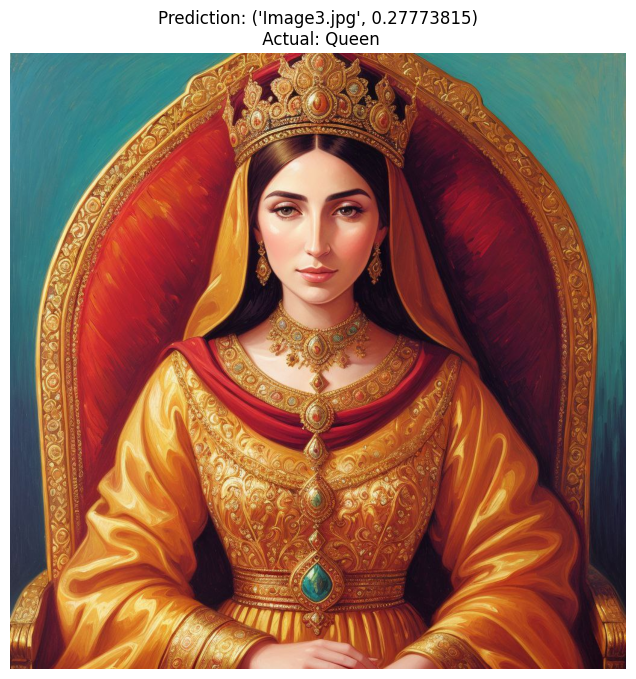

In [ ]:
print({word: accuracy for word, accuracy in zip(["king", "man", "queen", "woman"], queen_similarities)})
plt.figure(figsize=(12, 8))
image = Image.open(most_similar_images["queen_vector"][0])
plt.imshow(image)
plt.axis('off')

# Display label and similarity score
plt.title(f"Prediction: {most_similar_images['queen_vector']}\n Actual: Queen")
plt.show()


## *بخش دوم*

###  الف

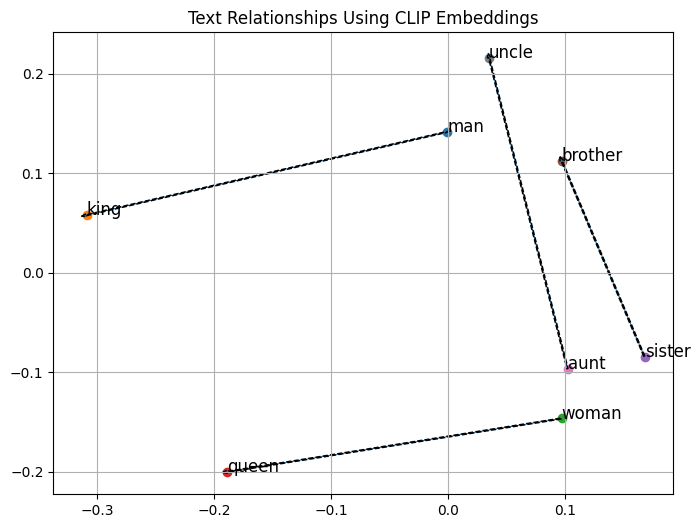

In [ ]:
texts = ["man", "king", "woman", "queen", "sister", "brother", "aunt", "uncle"]

embeddings = []
for text in texts:
    text_features = get_text_embedding(text)
    embeddings.append(text_features)

pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

plt.figure(figsize=(8, 6))
for i, text in enumerate(texts):
    plt.scatter(embeddings_2d[i, 0], embeddings_2d[i, 1])
    plt.text(embeddings_2d[i, 0], embeddings_2d[i, 1], text, fontsize=12)

pairs = [("man", "king"), ("woman", "queen"), ("sister", "brother"), ("aunt", "uncle")]
for text1, text2 in pairs:
    idx1, idx2 = texts.index(text1), texts.index(text2)
    plt.arrow(embeddings_2d[idx1, 0], embeddings_2d[idx1, 1],
              embeddings_2d[idx2, 0] - embeddings_2d[idx1, 0],
              embeddings_2d[idx2, 1] - embeddings_2d[idx1, 1],
              linestyle='--')


plt.title("Text Relationships Using CLIP Embeddings")
plt.grid(True)
plt.show()


### ب

In the secon part of question, looking at the relationships in this plot of word embeddings:


***1- Direction and Distance:***

* The direction and distance between word pairs like "man" to "king" and "woman" to "queen" are quite similar. This suggests that the model sees these pairs in a similar way, capturing relationships between gendered titles. The words are positioned in a way that shows these relationships clearly.

***2- Family Relationships and Variation in Relationships:***

* "aunt" and "uncle" are as almost close as "Sister" and "brother". This may show that the model sees "uncle" and "aunt" as similar as "brother" and "sister", but with more distanse. But since "brother" and "uncle" and similarly "aunt" and "sister" are not at the same position, it could be concluded the model can distinguish the relevance and relationships.

***3- Gender and Titles:***
  
* The famale titles have been located bottom of plot while the male titles are top of the plot; This relies on the model's capability to distinguish genders. Also The pairs "king"-"queen" and "man"-"woman" are positioned differently in the plot. Titles like "king" and "queen" are further to each other than "man" and "woman." This could mean that the model sees stronger connections between general gendered words than between royal titles.


## *بخش سوم*

### الف

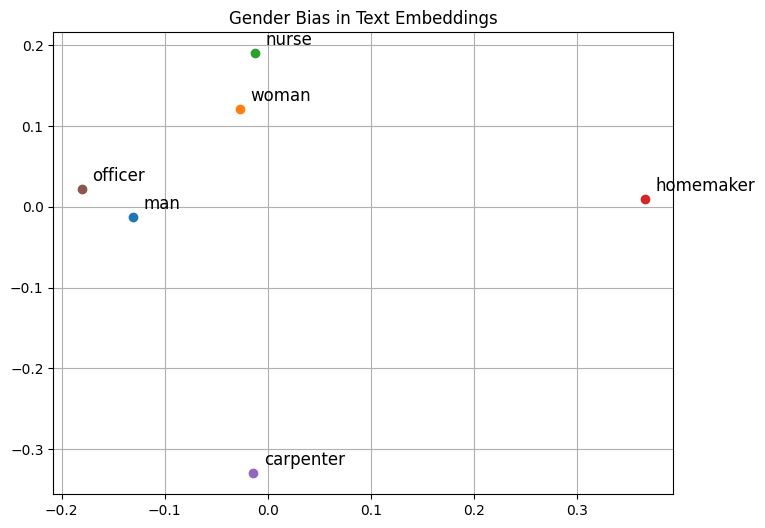

In [ ]:
texts = ["man", "woman", "nurse", "homemaker", "carpenter", "officer"]

embeddings = []
for text in texts:
    text_features = get_text_embedding(text)
    embeddings.append(text_features)

pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)


plt.figure(figsize=(8, 6))
for i, text in enumerate(texts):
    plt.scatter(embeddings_2d[i, 0], embeddings_2d[i, 1], marker='o')
    plt.text(embeddings_2d[i, 0] + 0.01, embeddings_2d[i, 1] + 0.01, text, fontsize=12)

plt.title("Gender Bias in Text Embeddings")
plt.grid(True)
plt.show()


### ب

This model is demonstrably gender biased. Words like "nurse," "woman," and "homemaker" are grouped together, while "officer," "man," and "carpenter" are close to each other. So the model associates certain roles with their related gender.

The best answer to why this is happening is the model's training on the data that contains these gendered associations, so it learned patterns that reflect social biases.

To reduce this associations, there are several ways. Some of them are:


1.   Regularization Techniques: Implement regularization techniques that penalize social associations
2.   Balanced Data: Use or create more balanced training data to associate all roles to both genders.
3.   Post-Processing: Modify the embedding vectors after training process.


